# Anxiety Test


Solution code for Thornquist test questions
RTB wrote it, 27 Oct 2017, EB transferred to Python 15 Oct, 2021

Questions 15-22 will be related to the same data ("anxiety.mat" in the
Desire2Learn Week 8 folder). Each patient is represented as a row, and
their normalized score on each test occupies each column (i.e. row 1 is
Patient 1, and the first column of row 1 is Patient 1's score on Test 1).

You are a researcher studying anxiety in humans, and you want to know if
a particular mutation makes people more likely to have anxiety. Each
patient takes 5 different tests that measure anxiety: 20 patients with a
known mutation ("experimental"), and 20 patients with the wild type
allele ("control"). You then normalize the data so that a score of 0 is
the population mean on the test, and a score of 1 is one standard
deviation away from the population mean, and use two-sample t-tests to
discern if there is a difference between the means of the two groups on
each test. The experimental and control scores are plotted here for each
test (mean +/- S.E.M.).

NOTE: originally called 'FWERwithCorrSim.m'


In [1]:
# Imports
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats 
import statsmodels.stats

## Load in data

In [2]:
# Download data from google drive
!gdown --id 1ui5ime4uWALqk3Doc_Jsz42RzoVTLMi3

# Load in data
data = sio.loadmat('/content/anxiety_assays.mat')
ctl = pd.DataFrame(data['ctl'])
expt = pd.DataFrame(data['expt'])

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ui5ime4uWALqk3Doc_Jsz42RzoVTLMi3
To: /content/anxiety_assays.mat
100% 1.88k/1.88k [00:00<00:00, 2.83MB/s]


## Plot the data


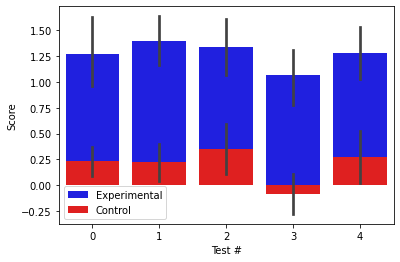

In [3]:
fig, ax = plt.subplots(1, 1)

sns.barplot(data = expt, ci = 68, color = 'b', ax = ax, label = 'Experimental')

sns.barplot(data = ctl, ci = 68, color = 'r', ax = ax, label = 'Control')

ax.legend()

ax.set(xlabel = 'Test #',
       ylabel = 'Score');

Feel free to use statsmodel or scipy options!

## Do separate 2-sample t-tests for each test


In [ ]:
# Calculate unadjusted p-values
t_stats, p_vals = scipy.stats.ttest_ind(ctl, expt, axis = 0)
print(p_vals)

[0.00607968 0.00028966 0.01155334 0.00156095 0.00928711]


**Q15**: Without making any post-hoc adjustments for multiple comparisons, on
which tests is there a significant difference between the "experimental"
and "control" treatments (at a significance level of p < 0.05)? (Check
all that apply)



**A15:** All p-values are below 0.05


**Q16**:  Using the standard Bonferroni correction are all of the tests still
significant at p < 0.05?


**A16**: No. We can adjust things in one of two ways:
  1. divide our criterion by the number of tests and use the same
     p-values
  2. multiply our p-values by the number of tests and use the same
     criterion


In [ ]:
n_tests = len(p_vals)
BC_p_vals = p_vals * n_tests

print(BC_p_vals)

[0.03039842 0.00144831 0.0577667  0.00780473 0.04643556]


**Q17:** Should you be concerned about multiple comparisons here?


**A17:** Yes; we performed multiple hypothesis tests, and so we have a higher
probability of at least one test rejecting the null hypothesis, even if
it's true, and so we should use a more stringent criterion.


## Assess correlation among tests

The purpose of multiple comparisons corrections is to address the fact
that, if you perform several independent hypothesis tests, each at a
particular level of significance, the probability that at least one will
give a false positive is higher than any of the individual tests. We're
doing something slightly different, which is asking whether 5 separate
tests are consistent with an underlying phenomenon: that the person is
"anxious."

**Q18:** In the data provided in the .mat file, is there evidence that
the tests results are correlated across patients?


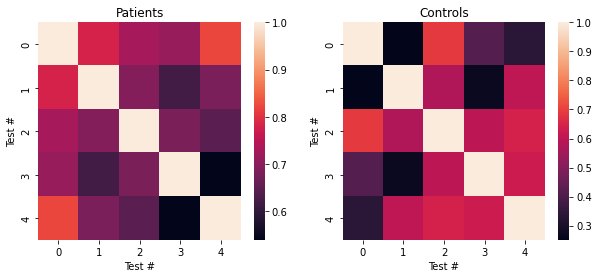

In [ ]:
ctl_corr = ctl.corr()
expt_corr = expt.corr()

# Visualize
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

sns.heatmap(expt_corr, ax = axes[0])
sns.heatmap(ctl_corr, ax = axes[1])

axes[0].set(title = 'Patients', 
            xlabel = 'Test #',
            ylabel = 'Test #')

axes[1].set(title = 'Controls', 
            xlabel = 'Test #',
            ylabel = 'Test #');

**A18**: Yes. In the experimental group, scores on all tests are correlated,
with correlation coefficients ranging from 0.54 to 0.82, and all are
statistically significant at p < 0.05. Similar for the control group,
thought tests 1 and 5 do not appear significantly correlated:


**Q19:** How should your findings about the correlations of the tests adjust
the way you think about correcting for the fact that you're performing
multiple comparisons?


**A19:** They are at least partially independent tests, so the probability of
observing at least one false positive across the whole set is higher than
the probability of rejecting the null hypothesis for any single test. We
should thus use a more stringent criterion for significance than p <
0.05, although not as stringent as if they were independent.

**Q#:** The authors cite your work in the statistics section as a
justification for not correcting for multiple comparisons. Based on their
evidence, should they be able to conclude that there are two types of
anxiety?

**A#:** No. The two situations are quite different. Your paper asked "do the
data support an underlying state of anxiety (as reflected by these 5
measures)?" and so your hypothesis testing produced results which were
correlated with each other and addressed a common question. These authors
ask "Is there a detectable state of anxiety, as reflected by at least one
test showing a significant difference?" and perform many hypothesis tests
which produce independent conclusions. As a result, they should correct
for false positives in those independent tests.


## Simulate data with different levels of correlation

The data provided in `anxiety_assays.mat` were made up. Data for each
group was generated using the MATLAB equivalent of `np.random.multivariate_normal(mu, sigma, size = (20, ))`, with a
different 'mu' for the experimental and control groups. Specifically,
`mu_expt = np.ones((5,))` and `mu_ctl = np.zeros((5,))`. They both used the same
covariance matrix.



In [ ]:
n_samp = 20     # number per group
my_corr = 0.6   # correlation among tests
mu_expt = np.ones((5,))   # normalized mean of experimental group
mu_ctrl = np.zeros((5,))  # normalized mean of control group

# covariance matrix:
my_sigma = (my_corr * np.ones((5,5))) + ((1 - my_corr) * np.eye(5))

You can see that every test is positively correlated with every other
test. Use a simulation to estimate the probability that you get a false
positive on one or more of the five tests (i.e. the 'Family-wise error
rate' or FWER) using this same covariance matrix and an 'n' of 20
patients in each group.


Q20: What is the probability of at least one false positive? 

In [ ]:
np.random.seed(123)

n_sim = 10000
n_FP = 0

for k in range(n_sim):
    R1 = np.random.multivariate_normal(mu_ctrl, my_sigma, size = (n_samp, ))
    R2 = np.random.multivariate_normal(mu_ctrl, my_sigma, size = (n_samp, ))
    t_stats, p_vals = scipy.stats.ttest_ind(R1, R2)
    if np.any(p_vals < 0.05):
         n_FP += 1

p_FP = n_FP / n_sim

print(p_FP)

0.1686


**Q21:** What is the probability of producing a false positive if the tests
are completely uncorrelated (i.e. sigma is 0 everywhere except the
main diagonal)?


A21: There are two different ways to answer this question. The simplest is to just generate a new covariance matrix and repeat our simulation(see code below). This gives 0.2175


In [ ]:
my_sigma = np.eye(5)

np.random.seed(123)

n_sim = 10000
n_FP = 0

for k in range(n_sim):
    R1 = np.random.multivariate_normal(mu_ctrl, my_sigma, size = (n_samp, ))
    R2 = np.random.multivariate_normal(mu_ctrl, my_sigma, size = (n_samp, ))
    t_stats, p_vals = scipy.stats.ttest_ind(R1, R2)
    if np.any(p_vals < 0.05):
         n_FP += 1

p_FP = n_FP / n_sim

print(p_FP)

0.2175


**Q22:** What is the probability if all tests scores are perfectly correlated?



**A22:** Again, two possible approaches. Simulation:
`my_sigma = np.ones((5, 5))` and repeat the full simulation. This gives 0.0461 (see cell below).


In [ ]:
my_sigma = np.ones((5,5))

np.random.seed(123)

n_sim = 10000
n_FP = 0

for k in range(n_sim):
    R1 = np.random.multivariate_normal(mu_ctrl, my_sigma, size = (n_samp, ))
    R2 = np.random.multivariate_normal(mu_ctrl, my_sigma, size = (n_samp, ))
    t_stats, p_vals = scipy.stats.ttest_ind(R1, R2)
    if np.any(p_vals < 0.05):
         n_FP += 1

p_FP = n_FP / n_sim

print(p_FP)

0.0461


Or you can just realize that if the scores all are perfectly correlated,
we have really only done one test, so FWER = alpha for single test.
Brian Healy gave an example in his multiple comparisons lecture of
comparing heights between two groups, but coding the heights (single
measurement) in five different ways: cm., in., ft., m., yds.